In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
import math
from scipy import interpolate
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import Counter
%matplotlib inline

train = pd.read_csv("Dataset_Training.csv")

In [2]:
from ipywidgets import interact
from tqdm.notebook import tqdm

In [3]:
# pip install scikit-plot 설치해주기!

In [4]:
# conda install -c conda-forge kaggle

make_time / holiday: https://dacon.io/competitions/official/235736/codeshare/2835?page=1&dtype=recent

In [5]:
# adding features related to datetime
status_map = {
    'abnormal' : 1,
    'normal' : 0
}
def make_time(df):
    for i in range(2,7):
        df['HHMMSS'] = df['HHMMSS'].astype('str').str.zfill(i)
    df['YYYYMMDD'] = df['YYYYMMDD'].astype('str')
    hhmmss = df['HHMMSS'].values.tolist()
    yyyymmdd = df['YYYYMMDD'].values.tolist()
    for i in range(len(df)):
        hhmmss[i] = hhmmss[i][:2]+':'+hhmmss[i][2:4]+':'+hhmmss[i][4:]
        yyyymmdd[i] = yyyymmdd[i][:4]+'-'+yyyymmdd[i][4:6]+'-'+yyyymmdd[i][6:]+' '
    df['HHMMSS'] = hhmmss
    df['YYYYMMDD'] = yyyymmdd
    df['Time'] = df['YYYYMMDD'] + df['HHMMSS']
    df = df.drop(['YYYYMMDD','HHMMSS'], axis=1)
    df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
    df['month'] = df['Time'].dt.month
    df['day'] = df['Time'].dt.day
    df['hour'] = df['Time'].dt.hour
    df['min'] = df['Time'].dt.minute
    df['second'] = df['Time'].dt.second
    df['dayofyear'] = df['Time'].dt.dayofyear 
    df['weekday'] = df['Time'].dt.weekday
    df.set_index('Time', inplace=True)
    # https://rudolf-2434.tistory.com/12
    df['status'] = df['status'].map(status_map)
    df.rename(columns={'status':'target'})
    return df

status열은 normal = 1, abnormal= 0으로 바꿔서 target열로 바꿔줬다.

train+test 데이터의 기간이 18/06/15~18/09/13까지이므로 그 날짜에 해당하는 공휴일들도 추가해준다.
- 6/6: 현충일
- 6/13: 지방선거
- 8/15 : 광복절

휴일은 아니지만 주의해야할 날들
- 7/17: 제헌절, 초복
- 7/27: 중복
- 8/16: 말복

In [6]:
def holiday(df):
    df.loc[df.weekday >= 5, 'holiday'] = 1
    df.loc[df.weekday < 5, 'holiday'] = 0
    df.loc[(df.month == 6) & (train.day == 6), 'holiday'] = 1
    df.loc[(df.month == 6) & (train.day == 13), 'holiday'] = 1
    df.loc[(df.month == 8) & (train.day == 15), 'holiday'] = 1
    return df

In [7]:
train = make_time(train)
train = holiday(train)

In [8]:
eda = train.copy()
eda = eda.dropna()
train_q = eda.copy()

## 결측치 확인

https://ettrends.etri.re.kr/ettrends/191/0905191014/145-153_%EA%B9%80%EC%97%90%EB%8D%B4.pdf
https://sosoeasy.tistory.com/444
- 완전무작위 결측 같아서 일단 삭제하고 진행하고, 아닐 경우에 대비하여 다른 보완법도 몇 가지 해봐야 함.
- 결측치에서 cpu나 memory가 너무 비정상이라 기록이 안 되었을 확률 고려해야 함.

In [9]:
train[train['CPU'].isnull() | (train['Memory'].isnull())]

,CPU,Memory,status,month,day,hour,min,second,dayofyear,weekday,holiday
Time,,,,,,,,,,,
2018-06-29 11:35:00,NaN,12.0,0,6,29,11,35,0,180,4,0.0
2018-07-31 15:10:00,NaN,5.0,0,7,31,15,10,0,212,1,0.0
2018-08-21 09:55:00,30.0,NaN,0,8,21,9,55,0,233,1,0.0


## 결측치 채우기

https://www.dacon.io/competitions/official/235736/codeshare/2844?page=2&dtype=recent

우선 train 데이터에 임의로 결측치를 생성하도록 하겠습니다.

In [10]:
def make_train_nan(col, n):
    new_list = []
    for idx, temp in enumerate(eda[col]):
        if (idx%n!=0) or (idx == 0):
            new_list.append(temp)
        else:
            new_list.append(np.nan)
    eda['{}'.format(col+'_nan')] = new_list

In [11]:
make_train_nan('CPU',3)
make_train_nan('Memory',3)

In [12]:
eda.head()

,CPU,Memory,status,month,day,hour,min,second,dayofyear,weekday,holiday,CPU_nan,Memory_nan
Time,,,,,,,,,,,,,
2018-06-15 00:00:00,17.0,2.0,0,6,15,0,0,0,166,4,0.0,17.0,2.0
2018-06-15 00:05:00,20.0,2.0,0,6,15,0,5,0,166,4,0.0,20.0,2.0
2018-06-15 00:10:00,21.0,2.0,0,6,15,0,10,0,166,4,0.0,21.0,2.0
2018-06-15 00:15:00,19.0,2.0,0,6,15,0,15,0,166,4,0.0,NaN,NaN
2018-06-15 00:20:00,45.0,2.0,0,6,15,0,20,0,166,4,0.0,45.0,2.0


In [13]:
eda.tail()

,CPU,Memory,status,month,day,hour,min,second,dayofyear,weekday,holiday,CPU_nan,Memory_nan
Time,,,,,,,,,,,,,
2018-08-23 23:35:00,15.0,1.0,0,8,23,23,35,0,235,3,0.0,15.0,1.0
2018-08-23 23:40:00,7.0,1.0,0,8,23,23,40,0,235,3,0.0,7.0,1.0
2018-08-23 23:45:00,6.0,2.0,0,8,23,23,45,0,235,3,0.0,NaN,NaN
2018-08-23 23:50:00,5.0,1.0,0,8,23,23,50,0,235,3,0.0,5.0,1.0
2018-08-23 23:55:00,5.0,1.0,0,8,23,23,55,0,235,3,0.0,5.0,1.0


In [14]:
print(eda.iloc[:,-2:].isnull().sum())

CPU_nan       6718
Memory_nan    6718
dtype: int64


In [15]:
eda = eda.astype(dtype='float64')

In [16]:
eda

,CPU,Memory,status,month,day,hour,min,second,dayofyear,weekday,holiday,CPU_nan,Memory_nan
Time,,,,,,,,,,,,,
2018-06-15 00:00:00,17.0,2.0,0.0,6.0,15.0,0.0,0.0,0.0,166.0,4.0,0.0,17.0,2.0
2018-06-15 00:05:00,20.0,2.0,0.0,6.0,15.0,0.0,5.0,0.0,166.0,4.0,0.0,20.0,2.0
2018-06-15 00:10:00,21.0,2.0,0.0,6.0,15.0,0.0,10.0,0.0,166.0,4.0,0.0,21.0,2.0
2018-06-15 00:15:00,19.0,2.0,0.0,6.0,15.0,0.0,15.0,0.0,166.0,4.0,0.0,NaN,NaN
2018-06-15 00:20:00,45.0,2.0,0.0,6.0,15.0,0.0,20.0,0.0,166.0,4.0,0.0,45.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-23 23:35:00,15.0,1.0,0.0,8.0,23.0,23.0,35.0,0.0,235.0,3.0,0.0,15.0,1.0
2018-08-23 23:40:00,7.0,1.0,0.0,8.0,23.0,23.0,40.0,0.0,235.0,3.0,0.0,7.0,1.0
2018-08-23 23:45:00,6.0,2.0,0.0,8.0,23.0,23.0,45.0,0.0,235.0,3.0,0.0,NaN,NaN


결측치가 잘 생성됨을 확인할 수 있습니다.
각 변수에 대해 8가지의 보간법을 시행한 후 가장 오차가 적은 보간법으로 결측치를 채워주겠습니다.
https://techblog-history-younghunjo1.tistory.com/85
https://rfriend.tistory.com/682
- pad, linear,'quadratic','cubic', XGboost, LightGBM, MICE, K-NN, multiquadratic

In [17]:
def compare_interpolate_methods(col, methods, metric):
    error_dict = dict()
    for method in methods:
        fillna = eda['{}'.format(col+'_nan')].interpolate(method=method)
        if fillna.isna().sum() != 0:
            fillna = fillna.interpolate(method='quadratic')
        error = metric(eda['{}'.format(col)], fillna)
        error_dict['{}'.format(method)] = error
    return error_dict    

In [18]:
def compare_interpolate_methods_(col, methods, metric, n):
    error_dict = dict()
    for method in methods:
        fillna = eda['{}'.format(col+'_nan')].interpolate(method=method, order=n)
        if fillna.isna().sum() != 0:
            fillna = fillna.interpolate(method='quadratic')
        error = metric(eda['{}'.format(col)], fillna)
        error_dict['{}'.format(method)] = error
        all_cols_error_dict['{}'.format(col)][method] = error_dict[method]

In [19]:
all_cols_error_dict = dict()
for col in ['CPU', 'Memory']:
    methods = ['pad','linear','quadratic','cubic', 'time', 'nearest', 'zero', 'slinear', 'pchip', 'akima', 'cubicspline']
    error_dict = compare_interpolate_methods(col, methods, mean_squared_error)
    all_cols_error_dict['{}'.format(col)] = error_dict
for col in ['CPU', 'Memory']:
    methods = ['spline', 'polynomial']
    error_dict = compare_interpolate_methods_(col, methods, mean_squared_error, 5)
    

In [20]:
all_cols_error_dict

{'CPU': {'pad': 4.152105968150022,
  'linear': 1.7042094557721883,
  'quadratic': 1.642347885017022,
  'cubic': 1.6757860562587685,
  'time': 1.704132283794436,
  'nearest': 4.149724661407948,
  'zero': 4.152105968150022,
  'slinear': 1.704132283794436,
  'pchip': 1.5769181893605495,
  'akima': 1.6152179779799452,
  'cubicspline': 1.6757860562587685,
  'spline': 1.9409242408690668,
  'polynomial': 1.8222511281588971},
 'Memory': {'pad': 1.1887681698665475,
  'linear': 0.44749962792082154,
  'quadratic': 0.3985791223402077,
  'cubic': 0.40704523046290036,
  'time': 0.4110551614272406,
  'nearest': 0.9082204693158704,
  'zero': 1.1887681698665475,
  'slinear': 0.4110551614272406,
  'pchip': 0.386153596122123,
  'akima': 0.3674451861595375,
  'cubicspline': 0.40704523046290025,
  'spline': 0.6028840669983554,
  'polynomial': 0.44205307705925356}}

def compare_interpolate_methods_(col, metric):
    error_dict = dict()
    for method in methods:
        for i in range(3,6):
            fillna = eda['{}'.format(col+'_nan')].interpolate(method=method, order = i)
            if fillna.isna().sum() != 0:
                fillna = fillna.interpolate(method='quadratic')
            error = metric(eda['{}'.format(col)], fillna)
            error_dict['%s - %d' %(method, i)] = error
            all_cols_error_dict['{}'.format(col)] = error_dict  

imit_direction='backward' 로 설정해주면 보간해주는 방향이 밑에서 위로 올라가면서 해주게 됩니다.
(아무런 설정을 안해주면 default 로 limit_direction='forward' 설정됨.  limit_direction='both' 도 있음)
df.interpolate(method='values', limit=1, limit_direction='backward')
https://rfriend.tistory.com/264
https://bskyvision.com/entry/model%EC%9D%84-%EC%BB%B4%ED%8C%8C%EC%9D%BC%ED%95%A0-%EB%95%8C-%EC%82%AC%EC%9A%A9%EB%90%98%EB%8A%94-loss%EC%99%80-metrics%EC%9D%B4%EB%9E%80-%EA%B7%B8-%EC%B0%A8%EC%9D%B4%EB%8A%94
https://bskyvision.com/822

mean_squared_error:https://growingsaja.tistory.com/233
https://mizykk.tistory.com/102
여기서는 mse만 썼는데 mae도 같이 써주는 게 좋을 듯

AutoTS 좋은점 

• 사용 중인 데이터 유형에 따라 달라지는 최적의 시계열 예측모형을 찾는 데 사용할 수 있음
• 일변량 시계열과 다변량 시계열을 모두 처리할 수 있음
• 또한 NaN값을 제거하고 채워 지저분한 데이터를 처리할 수 있으며 특이치도 처리할 수 있음 
• 이 파이썬 라이브러리에서 제공하는 모델을 배포에 사용할 수 있음

In [21]:
['linear', 'time', 'index', 'values', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic', 'barycentric', 'krogh', 'from_derivatives', 'pchip', 'akima', 'cubicspline']


['linear',
 'time',
 'index',
 'values',
 'nearest',
 'zero',
 'slinear',
 'quadratic',
 'cubic',
 'barycentric',
 'krogh',
 'from_derivatives',
 'pchip',
 'akima',
 'cubicspline']

In [22]:
all_cols_error_df = pd.DataFrame(all_cols_error_dict)
all_cols_error_df

,CPU,Memory
pad,4.152106,1.188768
linear,1.704209,0.447500
quadratic,1.642348,0.398579
cubic,1.675786,0.407045
time,1.704132,0.411055
nearest,4.149725,0.908220
zero,4.152106,1.188768
slinear,1.704132,0.411055
pchip,1.576918,0.386154
akima,1.615218,0.367445


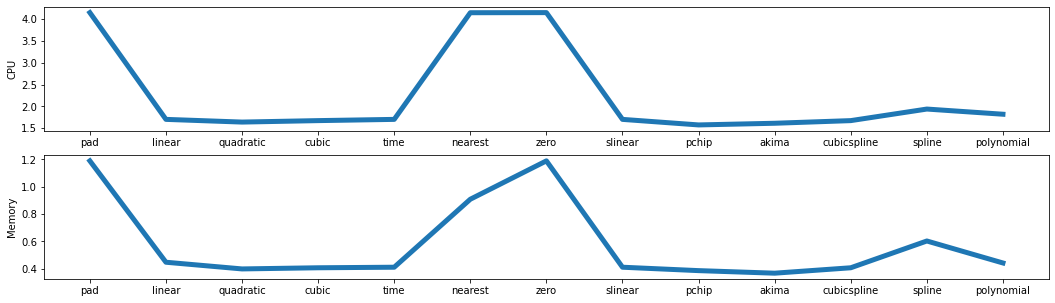

In [23]:
fig, axes = plt.subplots(2, 1, figsize = (18,5), sharey=False)
for i in range(len(all_cols_error_df.columns)):
    sns.lineplot(ax=axes[i], data=all_cols_error_df.iloc[:,i].transpose(), lw = 5)
    

In [24]:
train_q['CPU'] = train_q['CPU'].interpolate(method='pchip')
train_q['Memory'] = train_q['Memory'].interpolate(method='akima')

In [25]:
train_q

,CPU,Memory,status,month,day,hour,min,second,dayofyear,weekday,holiday
Time,,,,,,,,,,,
2018-06-15 00:00:00,17.0,2.0,0,6,15,0,0,0,166,4,0.0
2018-06-15 00:05:00,20.0,2.0,0,6,15,0,5,0,166,4,0.0
2018-06-15 00:10:00,21.0,2.0,0,6,15,0,10,0,166,4,0.0
2018-06-15 00:15:00,19.0,2.0,0,6,15,0,15,0,166,4,0.0
2018-06-15 00:20:00,45.0,2.0,0,6,15,0,20,0,166,4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-23 23:35:00,15.0,1.0,0,8,23,23,35,0,235,3,0.0
2018-08-23 23:40:00,7.0,1.0,0,8,23,23,40,0,235,3,0.0
2018-08-23 23:45:00,6.0,2.0,0,8,23,23,45,0,235,3,0.0


In [26]:
train_q.isnull().sum()

CPU          0
Memory       0
status       0
month        0
day          0
hour         0
min          0
second       0
dayofyear    0
weekday      0
holiday      0
dtype: int64

In [27]:
train_q.to_csv("11_14.csv", index = True)

## 월별

https://dacon.io/competitions/official/235736/codeshare/2835?page=1&dtype=recent
밑에 abnormal 발생한 날을 추가하고 싶음.

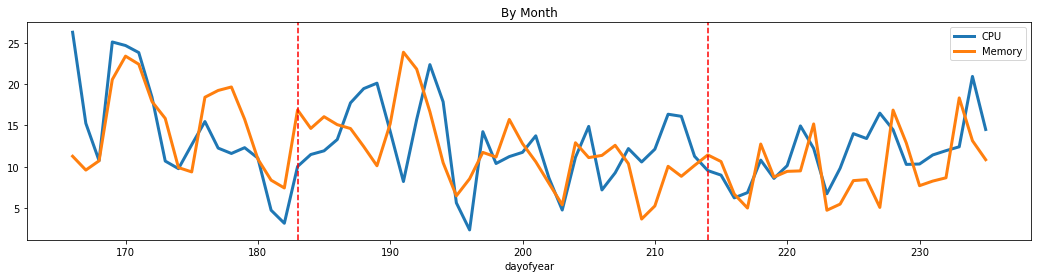

In [28]:
train.groupby(['dayofyear'])['CPU'].mean().plot(figsize=(18, 4), lw = 3)
(train.groupby(['dayofyear'])['Memory'].mean()*3.2).plot(figsize=(18, 4), lw=3)
plt.legend(['CPU', 'Memory'])
plt.axvline(x = 183, color = 'r', linestyle = '--',)
plt.axvline(x = 214, color = 'r', linestyle = '--',)
plt.title('By Month')
plt.show()

## 각 요일별

https://kibua20.tistory.com/195
https://dailyheumsi.tistory.com/98

화요일에 abnormal이 가장 많이 발생하였고 토요일엔 한 건도 발생하지 않았다.
-> 화요일 이상치 확인

In [29]:
train.groupby(['weekday'])['status'].sum()

weekday
0     2
1    14
2     8
3     2
4     3
5     0
6     4
Name: status, dtype: int64

(0.0, -0.25, 2.0, 0.5)
(0.0, 0.75, 14.0, 0.5)
(0.0, 1.75, 8.0, 0.5)
(0.0, 2.75, 2.0, 0.5)
(0.0, 3.75, 3.0, 0.5)
(0.0, 4.75, 0.0, 0.5)
(0.0, 5.75, 4.0, 0.5)


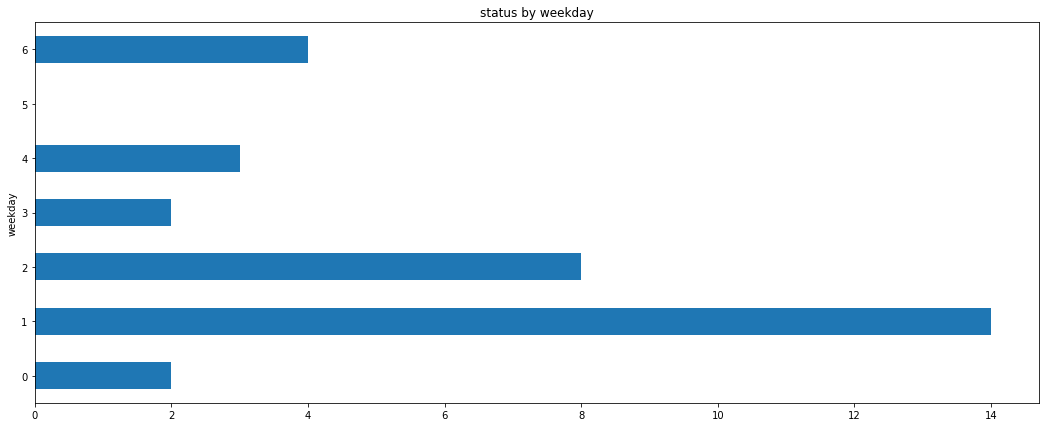

In [30]:
ax = (train.groupby(['weekday'])['status'].sum()).plot(kind='barh', figsize=(18, 7))
plt.title('status by weekday')
for p in ax.patches:
    x, y, width, height = p.get_bbox().bounds
    print(p.get_bbox().bounds)
plt.show()

## 시간대별(9-12/12-3/3-6)

<AxesSubplot:xlabel='weekday'>

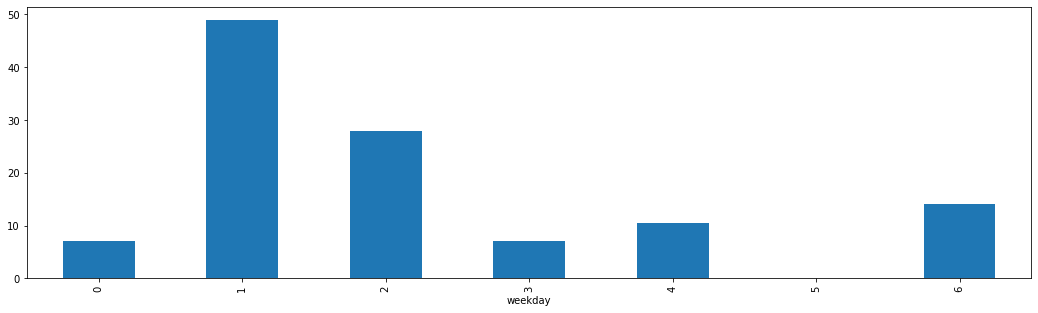

In [31]:
(train.groupby(['weekday'])['status'].sum()*3.5).plot(kind='bar', figsize=(18, 5))

<AxesSubplot:xlabel='hour,Time'>

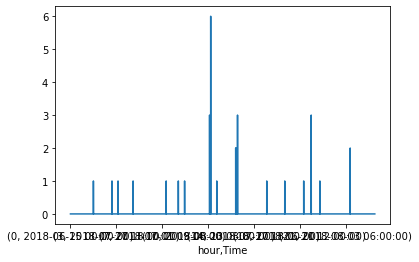

In [32]:
# 시간대별 이용비율
ax2 = train.groupby(['hour'])['status'].resample(rule='3H').sum()
ax2.plot()

날씨나 주요 뉴스?